## Solve.
The target of this nb is to solve an 9x9 sudoku grid with guessing algorithm.

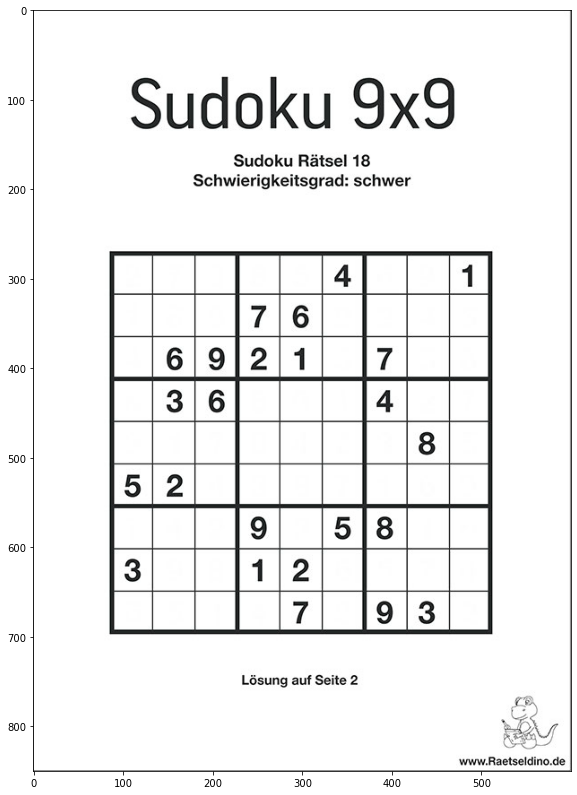

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

file_name = "sudoku-02-fuer-anfaenger.jpg"
file_name = "sudoku-14-schwer.jpg"
file_name = "sudoku-17-extra-schwer.jpg"
file_name = "sudoku-18-extra-schwer-gratis.jpg"
#file_name = "Sudoku-Raetsel-schwer-1.jpg"
img = cv.imread(file_name)
#img = img.astype(np.float32)   #ensure floating point numbers
orig = np.copy(img)

gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

#if len(img.shape) == 3: #3 dimensions: probably color channel in image
#    print("Reducing color image to grayscale")
#    img = np.sum(img, axis=2) #compress one image axis



def show(image, size_y = 10, size_x = 14):
    #cv2.imshow(img)


    fig = plt.figure(figsize = (size_y,size_x))
    spec = gridspec.GridSpec(ncols=1, nrows=1)
    ax = fig.add_subplot(spec[0])
    ax.imshow(image, cmap='gray')


    #plt.imshow(image, cmap='gray')
    #plt.colorbar()
    #return fig, spec
show(img)


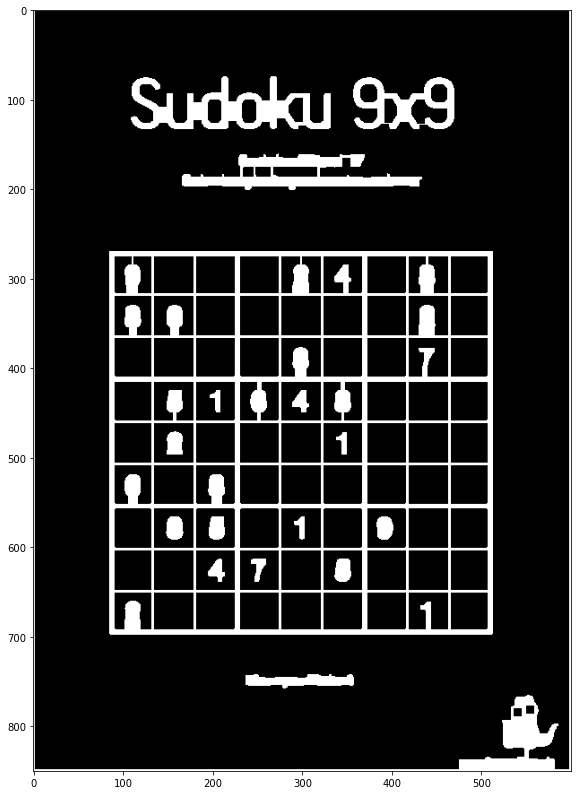

In [511]:
kernel = np.ones((5,5),np.uint8)
canny = cv.Canny(gray,60,170,apertureSize = 3)


dilate = cv.dilate(canny, kernel, iterations=2)
erode = cv.erode(dilate,kernel,iterations = 2)

#show(canny)
#show(dilate)
show(erode)

I've found 44 lines
combine_lines: 4 lines removed due too removeBorders operation
combine_lines: 20 lines removed due too combineClose operation
combine_lines: Found len(hlines)=10 and len(vlines)=10 in combineClose operation
Now there are 20 Lines


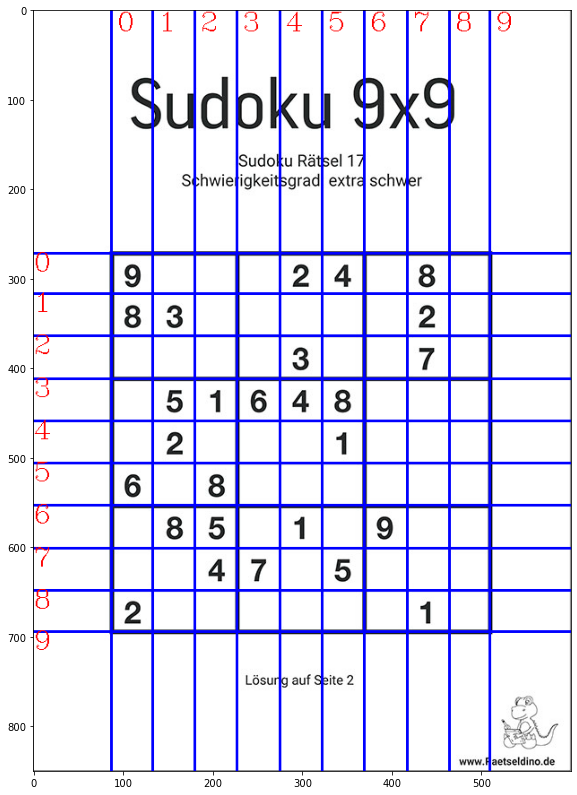

In [512]:
lines = cv.HoughLines(edges,1,np.pi/180, threshold=250)
def transform_lines(lines):
    '''
    Transforms lines into the cartesian coordinate room
    '''
    output = []
    if not lines.any():
        return output
    for line in lines:
        rho,theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        output.append([(y1, x1), (y2, x2)])
        #print(f"{x0=},{y0=} {x1=},{y1=}")
    return output

def combine_lines(lines, image_shape, isHoughRoom=False, removeBorders=True, threshold = 30):
    '''
    Combine nearby lines

    image_shape: (h, w), shape of the image
    isHoughRoom: Are the lines in the hough coordinate room format?
    removeBorders: Remove borders?

    returns: horizontal lines (y coordinates only), vertical lines (x coordinates only)
    '''
    h, w = image_shape
    if isHoughRoom:
        lines = transform_lines(lines)
    if removeBorders:
        output = []
        for line in lines:
            (y0, x0), (y1, x1) = line
            left = x0 < threshold and x1 < threshold
            right = x0 > w-threshold and x1 > w-threshold
            top = y0 < threshold and y1 < threshold
            bottom = y0 > (h-threshold) and y1 > (h-threshold)
            #print(line)
            #print(f"{x0=},{y0=} {x1=},{y1=}")
            #print(f"{top=} {bottom=} {left=} {right=}")
            #print(10*"-")
            if not (top or bottom or left or right):
                output.append(line)
        print(f"combine_lines: {len(lines)-len(output)} lines removed due too removeBorders operation")
        lines = output

    # Combine close
    hlines = []
    vlines = []
    processed_iis = []
    for ii, line in enumerate(lines):
        if ii in processed_iis:
            continue
        processed_iis.append(ii)
        (y0, x0), (y1, x1) = line

        found_pair = False
        for jj, other_line in enumerate(lines):
            if ii == jj or jj in processed_iis:
                continue
            (ny0, nx0), (ny1, nx1) = other_line

            # Horizontal Line
            if abs(x1-x0) > abs(y1-y0) and abs(nx1-nx0) > abs(ny1-ny0):
                #print(f"{abs(x1-x0)=} > {abs(y1-y0)=} and {abs(nx1-nx0)=} > {abs(ny1-ny0)=}:")
                #print(f"{abs(y0-ny0)=} < {threshold} and {abs(y1-ny1)=} < {threshold}")

                if abs(y0-ny0) < threshold and abs(y1-ny1) < threshold:
                    #my0 = my1 = int((y0 + y1 + ny0 + ny1)/4)
                    #mx0 = -w
                    #mx1 = w
                    #hlines.append([(my0, mx0), (my1, mx1)])
                    hlines.append(int((y0 + y1 + ny0 + ny1)/4))
                    processed_iis.append(jj)
                    found_pair = True
                    break

            # Vertical Line
            if abs(y1-y0) > abs(x1-x0) and abs(ny1-ny0) > abs(nx1-nx0):
                 if abs(x0-nx0) < threshold and abs(x1-nx1) < threshold:
                    #mx0 = mx1 = int((x0 + x1 + nx0 + nx1)/4)
                    #my0 = -h
                    #my1 = h
                    #vlines.append([(my0, mx0), (my1, mx1)])
                    vlines.append(int((x0 + x1 + nx0 + nx1)/4))
                    found_pair = True
                    processed_iis.append(jj)
                    break

        if not found_pair:
            if abs(y1-y0) > abs(x1-x0) and abs(ny1-ny0) > abs(nx1-nx0):
                vlines.append(int((x0 + x1)/2))
            elif abs(x1-x0) > abs(y1-y0) and abs(nx1-nx0) > abs(ny1-ny0):
                hlines.append(int((y0 + y1)/2))

    # Sort lines
    vlines.sort()
    hlines.sort()        

    print(f"combine_lines: {len(lines)-len(hlines)-len(vlines)} lines removed due too combineClose operation")
    print(f"combine_lines: Found {len(hlines)=} and {len(vlines)=} in combineClose operation")

    return hlines, vlines


print(f"I've found {len(lines)} lines")
lines = transform_lines(lines)
h, w, _ = orig.shape

hlines, vlines = combine_lines(lines, (h, w))
print(f"Now there are {len(hlines)+len(vlines)} Lines")

img = np.copy(orig)

for ii, y in enumerate(hlines):
    cv.line(img,(0, y),(w,y),(0,0,255),2)
    cv.putText(img, text=str(ii), org=(0, y+20), fontFace=cv.FONT_HERSHEY_COMPLEX, fontScale=1, color=(255, 0, 0))

for ii, x in enumerate(vlines):
    cv.line(img,(x, 0),(x,h),(0,0,255),2)
    cv.putText(img, text=str(ii), org=(x+6, 24), fontFace=cv.FONT_HERSHEY_COMPLEX, fontScale=1, color=(255,0 , 0))
show(img)

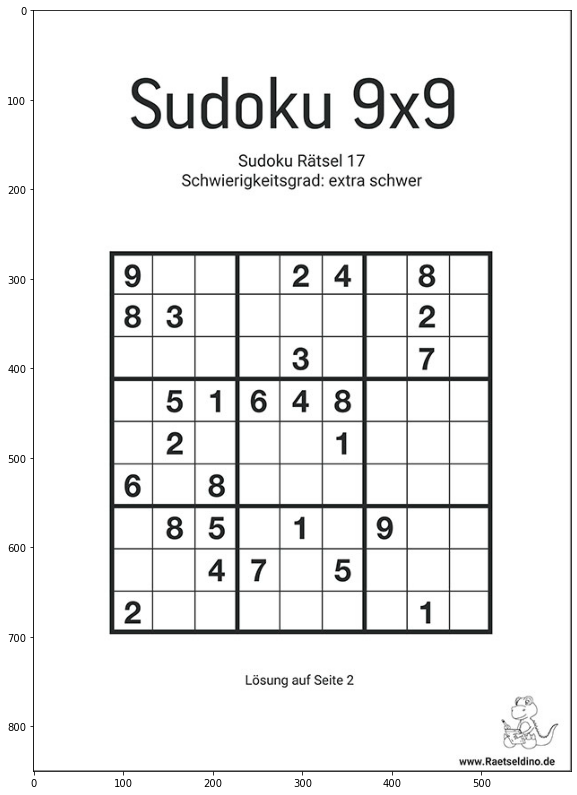

In [513]:
# Save Coordinate Pictures
img = np.copy(orig)

def coordinates_to_cell(img, hlines, vlines, coordinates):
    '''
    Converts 11-99 Coordinates to Cell

    coordinates = (v, h)
    returns (x0, y0), (x1, y1) coordinates for that specific cell
    '''
    if len(hlines) != 10 or len(vlines) != 10:
        raise Exception("False length of hlines or vlines")

    v, h = coordinates
    x0 = vlines[v-1]
    x1 = vlines[v-0]
    
    y0 = hlines[h-1]
    y1 = hlines[h-0]
    return (x0, y0), (x1, y1)

def cell_to_coordinates(img, hlines, vlines, cell):
    '''
    Converts cell (x, y) Coordinates to coordinates

    cell = (x, y)
    returns (v, h)
    '''
    x, y = cell
    v = h = 0
    for i in range(len(vlines)-1):
        if vlines[i] <= x < vlines[i+1]:
            v = i + 1
    for i in range(len(hlines)-1):
        if hlines[i] <= y < hlines[i+1]:
            h = i + 1  
    return v, h  

def print_cell(img, hlines, vlines, coordinates, text, color=(255,0 , 0)):
    (x0, y0), (x1, y1) = coordinates_to_cell(img, hlines, vlines, coordinates)

    x = int(0.5*(x0+x1))-10
    y = int(0.5*(y0+y1))+10
    cv.putText(img, text=str(text), org=(x, y), fontFace=cv.FONT_HERSHEY_COMPLEX, fontScale=1, color=color, bottomLeftOrigin = False )

def save_pattern(img, coordinates, hlines, vlines, digit, scale = 0.75):
    '''
    Converts 11-99 Coordinates to Cell

    :param: coordinates = (v, h)
    :param: hlines: horizontal lines
    :param: vlines: vertical lines
    :param: digit: The digit in the cell
    :scale: scale
    returns None
    '''
    (x0, y0), (x1, y1) = coordinates_to_cell(img, hlines, vlines, coordinates)

    w_tran = int((x1-x0) * (1-scale))
    h_tran = int((y1-y0)* (1-scale))
    tx0 = (x0+w_tran)
    tx1 = (x1-w_tran)
    ty0 = (y0+h_tran)
    ty1 = (y1-h_tran)

    cropped = img[ty0:ty1, tx0:tx1]
    cv.imwrite(f'digits/{digit}.png', cropped)
    cv.rectangle(img, (x0, y0), (x1, y1), color = (255, 0, 0), 	thickness = 2)

if 0:
    save_pattern(img, (1,1), digit=3, hlines=hlines, vlines=vlines)
    save_pattern(img, (2,1), digit=1, hlines=hlines, vlines=vlines)
    save_pattern(img, (3,1), digit=6, hlines=hlines, vlines=vlines)
    save_pattern(img, (4,1), digit=4, hlines=hlines, vlines=vlines)
    save_pattern(img, (6,1), digit=8, hlines=hlines, vlines=vlines)
    save_pattern(img, (8,1), digit=2, hlines=hlines, vlines=vlines)
    save_pattern(img, (9,1), digit=5, hlines=hlines, vlines=vlines)
    save_pattern(img, (3,2), digit=9, hlines=hlines, vlines=vlines)
    save_pattern(img, (1,3), digit=7, hlines=hlines, vlines=vlines)

show(img)

1
2
3
4
5
6
7
8
9
[[9 0 0 0 2 4 0 8 0]
 [8 3 0 0 0 0 0 2 0]
 [0 0 0 0 3 0 0 7 0]
 [0 5 1 6 4 8 0 0 0]
 [0 2 0 0 0 1 0 0 0]
 [6 0 8 0 0 0 0 0 0]
 [0 8 5 0 1 0 9 0 0]
 [0 0 4 7 0 5 0 0 0]
 [2 0 0 0 0 0 0 1 0]]
[[0.815 0.    0.    0.    0.772 0.865 0.    0.836 0.   ]
 [0.831 0.796 0.    0.    0.    0.    0.    0.764 0.   ]
 [0.    0.    0.    0.    0.798 0.    0.    0.876 0.   ]
 [0.    0.845 0.838 0.84  0.85  0.845 0.    0.    0.   ]
 [0.    0.78  0.    0.    0.    0.835 0.    0.    0.   ]
 [0.817 0.    0.826 0.    0.    0.    0.    0.    0.   ]
 [0.    0.817 0.818 0.    0.835 0.    0.812 0.    0.   ]
 [0.    0.    0.857 0.862 0.    0.83  0.    0.    0.   ]
 [0.772 0.    0.    0.    0.    0.    0.    0.845 0.   ]]


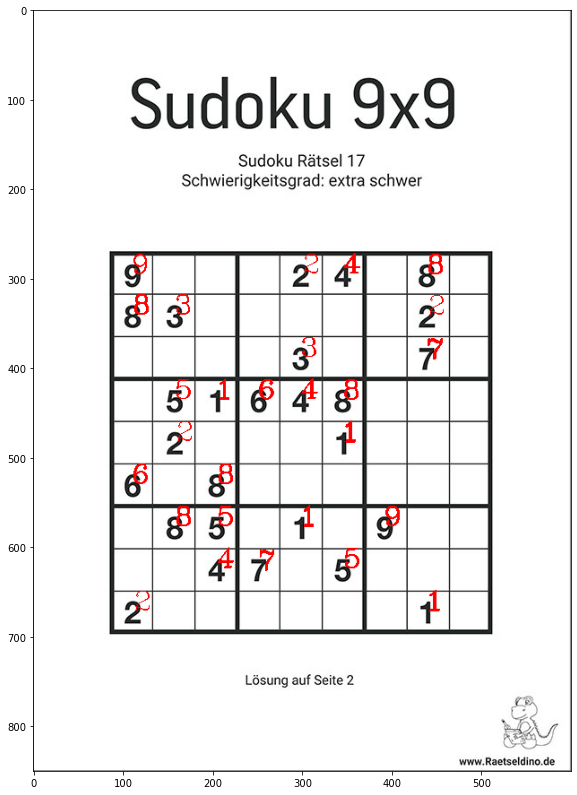

In [514]:
# Search digits
img = np.copy(orig)
pattern = np.zeros((9, 9), dtype=np.uint8)
thresholds = np.zeros((9, 9), dtype=np.float32)

#methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            # 'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF',       'cv.TM_SQDIFF_NORMED']
for i in range(1,10):
    d_img = cv.imread(f"digits/{i}.png")
    d_h, d_w, _ = d_img.shape

    res = cv.matchTemplate(img,d_img, cv.TM_CCOEFF_NORMED)
    threshold = 0.75
    loc = np.where( res >= threshold)
    for pt in zip(*loc[::-1]):
        x = int(pt[0] + 0.5 * d_w)
        y = int(pt[1] + 0.5 * d_h)

        #cv.circle(img, (x, y), color=(255, 0, 0), thickness = 2, radius = 10)
        cv.putText(img, text=str(i), org=(x, y), fontFace=cv.FONT_HERSHEY_COMPLEX, fontScale=1, color=(255,0 , 0))


        v, h = cell_to_coordinates(img, hlines, vlines, cell=(x, y))

        thres = res[pt[1]][pt[0]]

        # Check for better matching values
        if thres > thresholds[h-1][v-1]:
            if pattern[h-1][v-1] != 0:
                pass
                #print(f"Replacing { pattern[h-1][v-1]} with {i}")
            pattern[h-1][v-1] = i
            thresholds[h-1][v-1] = round(thres, 3)

        

show(img)
print(pattern)
orig_pattern = np.copy(pattern)
print(thresholds)

Wall time: 413 ms


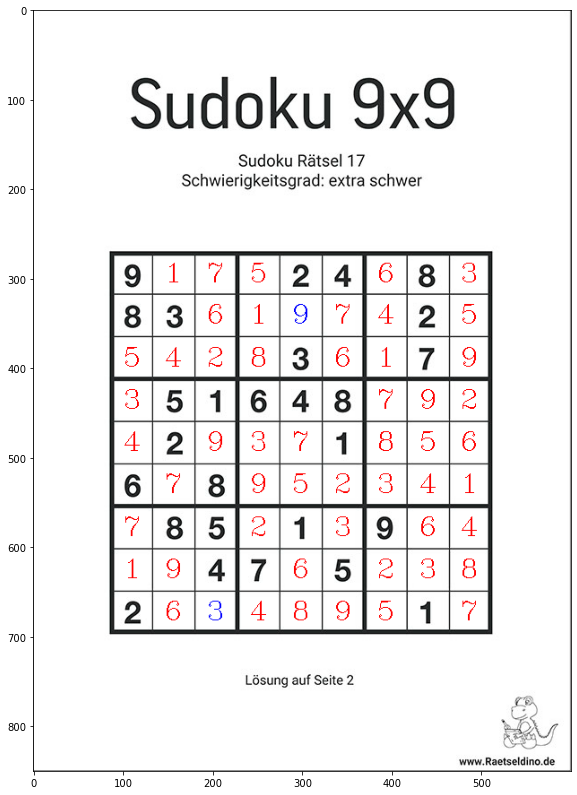

In [526]:
%%time 
#  Check integrity
digits_range = set(range(1,10))
img = np.copy(orig)
pattern = np.copy(orig_pattern)

last_zeros = np.count_nonzero(pattern==0)
guessing = False
guessing_constraint = 0
subset_constraint = 2

while (np.count_nonzero(pattern==0)) > 0:
    last_zeros = np.count_nonzero(pattern==0)

    for v in range(9):
        for h in range(9):
            if pattern[h][v] != 0:
                continue

            digits_found = set()
            # horizontal line
            for vv in range(9):
                if vv == v:
                    continue
                digits_found.add(pattern[h][vv])

            # vertical line
            for hh in range(9):
                if hh == h:
                    continue
                digits_found.add(pattern[hh][v])

            # block
            v_shift = v % 3
            h_shift = h % 3

            for vv in range(3):
                for hh in range(3):
                    nv = v+vv-v_shift
                    nh = h+hh-h_shift
                    #print(f"{nh=} {nv=}")
                    digits_found.add(pattern[nh][nv])
                    #print_cell(img, hlines, vlines, (nh+1, nv+1), f"c")
                    
            
            #print(f"{h=} {v=}, {subset=}")
            #print(f"{subset_constraint=}, {guessing_constraint=}, {guessing_counter=}")
            subset = digits_range - digits_found
            if len(subset) == 1:
                #print(f"len(subset) == 1: {h=} {v=}, {subset=}")

                digit = subset.pop()
                pattern[h][v] =digit
                print_cell(img, hlines, vlines, (v+1, h+1), digit)

            elif len(subset) == subset_constraint and guessing:
                guessing_counter += 1

                if guessing_counter == guessing_constraint:
                    #print(f"Guessing")
                    from random import randint
                    digit = subset.pop()
                    for i in range(randint(0, subset_constraint-1)):
                        digit = subset.pop()
                    pattern[h][v] =digit
                    print_cell(img, hlines, vlines, (v+1, h+1), digit, color = (0,0,255))
                    guessing=False
                elif guessing_counter > guessing_constraint:
                    guessing_counter == 0
            elif len(subset)==0:
                #print("Resetting")
                pattern = np.copy(orig_pattern)
                img = np.copy(orig)
            #print(f"zeros left {np.count_nonzero(pattern==0)}")

    if last_zeros == np.count_nonzero(pattern==0):#np.count_nonzero(pattern==0) >= zeros_at_start-1:
        #print(f"Setting guessing {subset_constraint=}, {guessing_constraint=}, {guessing_counter=}")
        guessing = True
        guessing_constraint +=1
        if guessing_constraint > 4:
            guessing_constraint = 0
            subset_constraint +=1
        if subset_constraint > 8:
            subset_constraint = 2
        guessing_counter = 0

show(img)

In [517]:
pattern

array([[9, 1, 7, 5, 2, 4, 6, 8, 3],
       [8, 3, 6, 1, 9, 7, 4, 2, 5],
       [5, 4, 2, 8, 3, 6, 1, 7, 9],
       [3, 5, 1, 6, 4, 8, 7, 9, 2],
       [4, 2, 9, 3, 7, 1, 8, 5, 6],
       [6, 7, 8, 9, 5, 2, 3, 4, 1],
       [7, 8, 5, 2, 1, 3, 9, 6, 4],
       [1, 9, 4, 7, 6, 5, 2, 3, 8],
       [2, 6, 3, 4, 8, 9, 5, 1, 7]], dtype=uint8)